In [1]:
import numpy as np
import pandas as pd

In [2]:
# load data
df_class = pd.read_csv(r'C:\Users\fyang\CCS-Prediction-paper\Data\classifier_model_data.csv')

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Random forest classifier modeling
from sklearn.model_selection import train_test_split

X_SC = df_class.iloc[:,12:]
y_SC = df_class['Super.Class'].values

X_SC_train, X_SC_test, y_SC_train, y_SC_test = train_test_split(X_SC, y_SC, 
                                                                train_size = 0.8, 
                                                                test_size=0.2, 
                                                                random_state=101,
                                                                stratify=y_SC)

print('X_SC_train: {}'.format(np.shape(X_SC_train)))
print('y_SC_train: {}'.format(np.shape(y_SC_train)))
print('X_SC_test: {}'.format(np.shape(X_SC_test)))
print('y_SC_test: {}'.format(np.shape(y_SC_test)))

X_SC_train: (836, 1022)
y_SC_train: (836,)
X_SC_test: (210, 1022)
y_SC_test: (210,)


In [6]:
# check training data
unique, counts = np.unique(y_SC_train, return_counts=True)
print (np.asarray((unique, counts)).T)

[['Benzenoids' 181]
 ['Lipids and lipid-like molecules' 189]
 ['Organic acids and derivatives' 184]
 ['Organic oxygen compounds' 142]
 ['Organoheterocyclic compounds' 140]]


In [7]:
# check test data
unique_test, counts_test = np.unique(y_SC_test, return_counts=True)
print (np.asarray((unique_test, counts_test)).T)

[['Benzenoids' 46]
 ['Lipids and lipid-like molecules' 47]
 ['Organic acids and derivatives' 46]
 ['Organic oxygen compounds' 36]
 ['Organoheterocyclic compounds' 35]]


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [9]:
# set parameters for tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
# Quality of a split
criterion = ['gini']
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 5, num =3)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 15, num =5)]
# Use out-of-bag samples to estimate the generalization score. 
oob_score = [True]

In [10]:
# Creat the param grid
param_grid = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
# Define model type
rfc_Model = RandomForestClassifier(oob_score = [True])

In [11]:
rfc_Grid = GridSearchCV(estimator = rfc_Model, 
                       param_grid = param_grid, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True
                       )


rfc_Grid.fit(X_SC_train, y_SC_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 7, 10, 12, 15],
                         'n_estimators': [100, 125, 150, 175, 200]},
             return_train_score=True, verbose=2)

In [12]:
# Optimized method 
print(rfc_Grid.best_params_)
print (f'Train Accuracy - : {rfc_Grid.score(X_SC_train,y_SC_train):.3f}')
print (f'Test Accuracy - : {rfc_Grid.score(X_SC_test,y_SC_test):.3f}')

{'min_samples_leaf': 5, 'n_estimators': 200}
Train Accuracy - : 0.941
Test Accuracy - : 0.833


In [13]:
labels = ['Organic acids and derivatives', 
                        'Lipids and lipid-like molecules',
                        'Benzenoids', 
                        'Organic oxygen compounds',
                        'Organoheterocyclic compounds']

In [14]:
# F1 Scores
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, average = None, labels = labels)

pred=rfc_Grid.predict(X_SC_test)

f1_score = f1_score(y_SC_test, pred, average= None,
             labels = labels)
f1_score

array([0.8372093 , 0.87912088, 0.82978723, 0.86567164, 0.75609756])

In [17]:
import matplotlib.pyplot as plt
# Plot results

def plot_search_results(grid):

    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

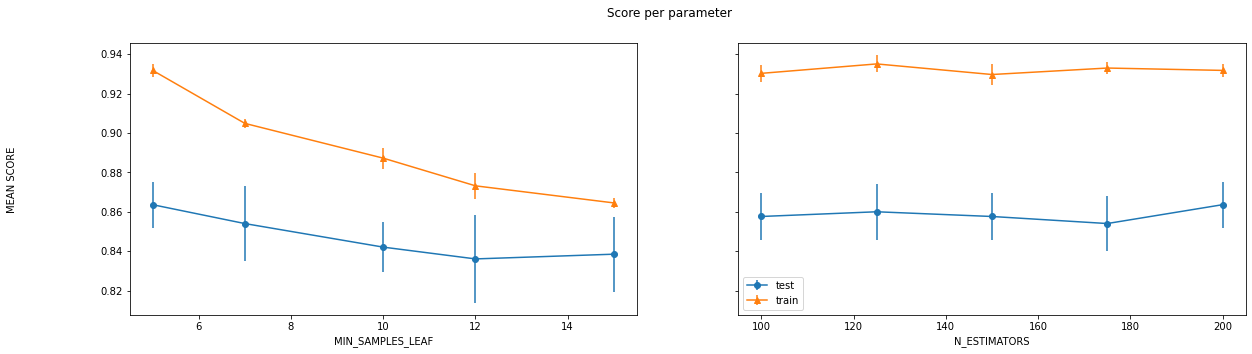

In [18]:
plot_search_results(rfc_Grid)

In [19]:
#Evaluation confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
matrix = confusion_matrix(y_SC_test, pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

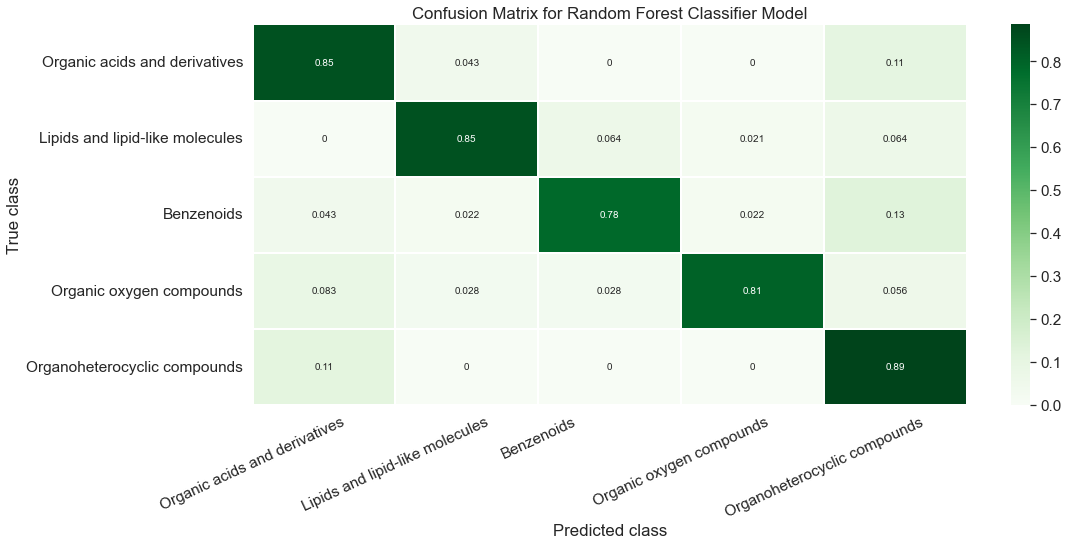

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
labels # SuperClass name

tick_marks = np.arange(len(labels))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, labels, rotation=25)
plt.yticks(tick_marks2, labels, rotation=0)
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.savefig('Confusion Matrix.png',bbox_inches='tight')
plt.show()

In [136]:
# get index of test datasets
l_SCtest_index = list(X_SC_test.index.values)
# get test dataset smiles
l_SCtest_smiles = df_class['SMILES'].loc[l_SCtest_index]
l_SCtest_names = df_class['name'].loc[l_SCtest_index]

In [137]:
# Check wrongly predicted chemicals
dict = {'name':l_SCtest_names, 'SMILES':l_SCtest_smiles, 'SuperClass':y_SC_test, 'Prediction':pred}
df_evalu = pd.DataFrame(dict)

In [138]:
# Compare predicted to defined class
df_evalu['comparison_column'] = np.where(df_evalu["SuperClass"] == df_evalu["Prediction"], 
                                           True, False)

In [139]:
df_evalu.drop(df_evalu[df_evalu['comparison_column'] == True].index, 
              inplace = True)

In [140]:
# randomly choose 3 confusion predicted chemicals from each class
wrongPred = df_evalu.groupby('SuperClass').apply(pd.DataFrame.sample, n = 3)

11-beta-Prostaglandin F2alpha


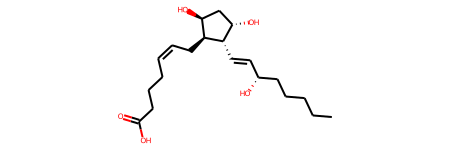

Naringenin


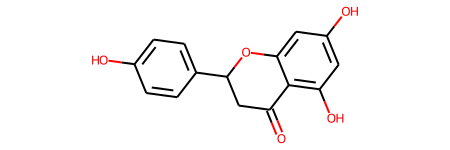

Pinostrobin


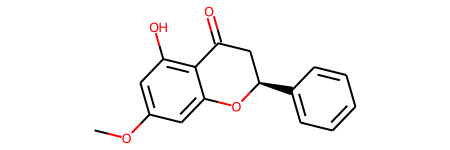

beta-Glycerophosphate


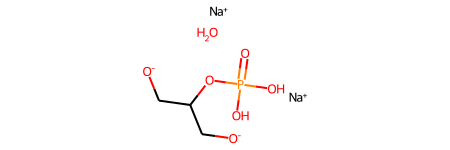

gamma,beta-Tocopherol


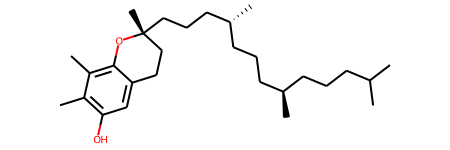

1-Stearoyl-2-oleoyl-sn-glycero-3-phosphoethanolamine


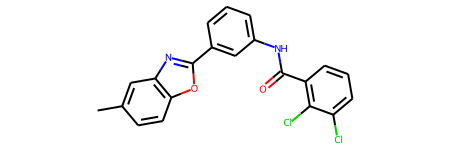

(S)-Adenosyl-L-methionine


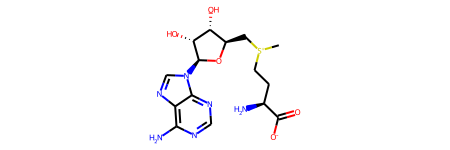

Daptomycin


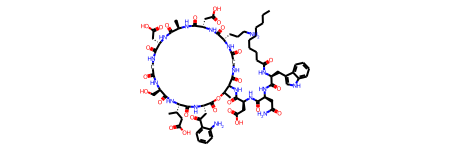

2-ethylhexyl phenyl phosphate


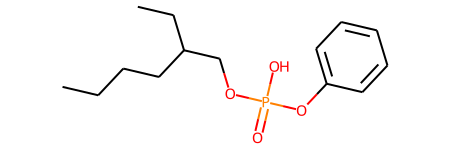

Adenosine 5' Diphosphoglucose


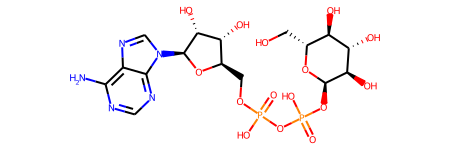

p-Nitrophenol


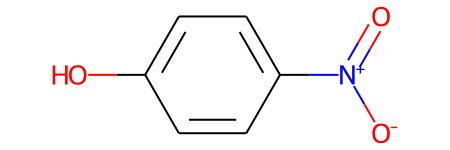

D-(-)-Tartartic Acid


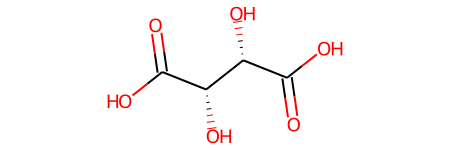

Umbelliferone


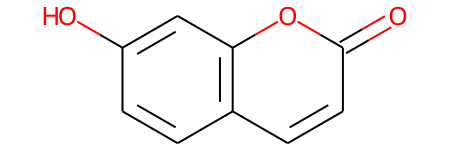

Anthraquinone (AQU)


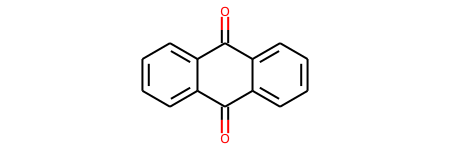

Salsolinol


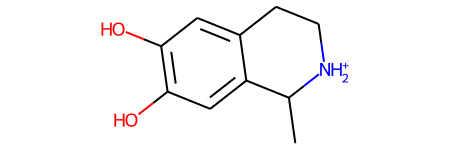

In [165]:
# get index of random choose chemicals
l_wrongPred_index = [i[1] for i in list(wrongPred.index.values)]
for i in l_wrongPred_index:
    print(df_class['name'][i])
    display(df_class['Molecule'][i])

In [23]:
# Feature importance
opt_model = rfc_Grid.best_estimator_ # best optimized model
model_FI = opt_model.feature_importances_

In [49]:
# investigate the top 10 importance features
ind = np.argpartition(model_FI,-10)[-10:] 
print(ind)
print(model_FI[ind])

[758 787 222 334 101 261 790 887 328 292]
[0.00862564 0.00903059 0.00941881 0.00910338 0.0112812  0.0124466
 0.01551259 0.01259312 0.01549926 0.01248307]


In [59]:
from rdkit.Chem import Draw
from rdkit import Chem

# get molecules from smiles
df_class['Molecule'] = [Chem.MolFromSmiles (x) for x in df_class.SMILES]

# get bits which have top10 highest importance features
FPs_columns = [f'Bit_{i}' for i in ind]

# collect chemicals with the presence of selected features
listOf_df_FI = [df_class.loc[df_class[column] == 1] for column in FPs_columns]

In [109]:
# get feature examples
def get_svgs(df,FI_index):
    
    rdkbi = {}
    
    for mol in df['Molecule']:
        rdkfp = Chem.RDKFingerprint(mol, 2, fpSize = 1024, bitInfo=rdkbi)
        svg = Draw.DrawRDKitBit(mol, FI_index, rdkbi, useSVG=True)
        return(svg)

292


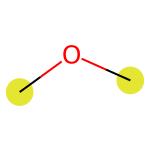

In [111]:
# display features
from IPython.core.display import display
df_FI = listOf_df_FI[0]
df_sampleFI = df_FI.sample(n = 1)    
svg = get_svgs(df_sampleFI, ind[0])
print(ind[i])
display(svg)

In [52]:
# save the model
import joblib
filename = 'classifier_prediction.sav'
joblib.dump(rfc_Grid, filename)

['classifier_prediction.sav']